<a href="https://colab.research.google.com/github/plaban1981/Dockship/blob/main/Richter's_Predictor_Modeling_Earthquake_Damage_(1)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem description
We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

* 1 represents low damage
* 2 represents a medium amount of damage
* 3 represents almost complete destruction

## Evaluation Metrics
micro averaged F1 score

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 85kB/s 


In [ ]:
!pip install yellowbrick

In [ ]:
!mkdir "/content/earthquake"

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
import shutil
shutil.move("/content/train_values.csv","/content/earthquake")

'/content/earthquake/train_values.csv'

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
shutil.move("/content/submission_format.csv","/content/drive/MyDrive/ritcher_earthquake")

'/content/drive/MyDrive/ritcher_earthquake/submission_format.csv'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [4]:
df = pd.concat([pd.read_csv(f,encoding='latin1', index_col='building_id') for f in glob.glob('/content/drive/MyDrive/ritcher_earthquake/earthquake/train*.csv')], axis=1)
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [5]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [6]:
# remove index Name
df = df.rename_axis(None).reset_index()
df.drop('index',axis=1,inplace=True)
df.head()


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## Summary Statistics


In [7]:
df.describe(include='all')

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601,260601,260601,260601,260601,260601,260601,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5,3,5,4,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,r,n,f,q,s,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216757,219196,182842,209619,165282,202090,250072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,NaN,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,NaN,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


## Visualize Labels

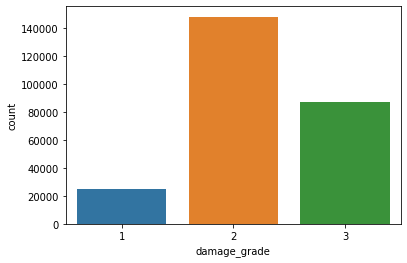

In [8]:
sns.countplot(x='damage_grade',data=df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 

## Numeric Features

In [7]:
X = df.drop('damage_grade',axis=1)
Y = df['damage_grade']

In [11]:
X.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

In [8]:
Y.head()

0    3
1    2
2    3
3    2
4    3
Name: damage_grade, dtype: int64

In [9]:
num_features = []
cat_features = []
for col in X.columns.tolist():
  if X[col].dtypes == 'O':
    cat_features.append(col)
  else:
    num_features.append(col)

In [10]:
cat_features

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [11]:
X[cat_features].head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,t,r,n,f,q,t,d,v
1,o,r,n,x,q,s,d,v
2,t,r,n,f,x,t,d,v
3,t,r,n,f,x,s,d,v
4,t,r,n,f,x,s,d,v


In [12]:
X[num_features].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Catboost Classifier

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.model_selection import *

## Hyperparameter Tuning for CatboostClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
gridParams = {
    'max_depth': [4,6,8,10,15,20],
    'num_boost_round': [1000,2000,2500,3000],
    'random_state' : [42,50,60,70,90]
    }
catboost = CatBoostClassifier(eval_metric='AUC',auto_class_weights='Balanced',verbose=0)
grid = RandomizedSearchCV(catboost, gridParams, verbose=2, cv=5, n_jobs=4)
# Run the grid
grid.fit(X, Y,cat_features = cat_features)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## Applying Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
iterations = 5
scores = []
scores_val = []
target = Y
temp = X
predictions = []
for i in range(iterations):
    print(f'Running {i+1} iteration')
    
    kfold = StratifiedKFold(n_splits = 2, shuffle=True)
    
    for train_index,test_index in kfold.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        #model  = CatBoostClassifier(learning_rate = 0.04627007502666947, n_estimators =200, max_depth =3,random_state = 60)    
        model = CatBoostClassifier(max_depth=12,
                                   random_state=60,
                                   eval_metric='AUC',
                                   auto_class_weights='Balanced',
                                   num_boost_round=1000,verbose=0)
        model.fit(xtrain,ytrain,cat_features = cat_features)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds,average='micro'))
        scores.append(f1_score(ytest,preds,average='micro'))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

Running 1 iteration
0.6973699357641154
0.6962701458173446
Running 2 iteration
0.6944919839448661


## Predictions on test data

In [13]:
#read in test data
test_data = pd.read_csv("/content/drive/MyDrive/ritcher_earthquake/test_values.csv", index_col='building_id')

test_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [14]:
test = test_data.copy()
# remove index Name
test = test.rename_axis(None).reset_index()
test.drop('index',axis=1,inplace=True)
print(test.head())

   geo_level_1_id  ...  has_secondary_use_other
0              17  ...                        0
1               6  ...                        0
2              22  ...                        0
3              26  ...                        0
4              17  ...                        0

[5 rows x 38 columns]


In [ ]:
#predict on test with hgb 
submission_pred = hgb_grid.predict(test)

In [ ]:
#create submission file
submission = pd.DataFrame(data=submission_pred, columns=['damage_grade']).set_index(test_data.index)

In [ ]:
submission = submission.reset_index()

In [ ]:
submission.to_csv("HistGradientClassifier.csv",index=False)

## **HistGradientClassifier**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_features = [0,1,2,3,4,5,6]
categorical_features = [7,8,9,10,11,12,13,25]
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder())
Preprocessor = ColumnTransformer(
 transformers=[
 ('numeric_transformer', numeric_transformer, numeric_features),
 ('categorical_transformer', categorical_transformer, categorical_features)
 ])

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [ ]:
hgb_pipe = make_pipeline(Preprocessor,HistGradientBoostingClassifier())

In [ ]:
from sklearn.model_selection import GridSearchCV
#parameters to tune
parameters = {
 'histgradientboostingclassifier__max_iter': [1000,1200,1500],
 'histgradientboostingclassifier__learning_rate': [0.1],
 'histgradientboostingclassifier__max_depth' : [25, 50, 75],
 'histgradientboostingclassifier__l2_regularization': [1.5],
 'histgradientboostingclassifier__scoring': ['f1_micro'],
 'histgradientboostingclassifier__random_state' : [42,52,60,100],
 }
#instantiate the gridsearch
hgb_grid = GridSearchCV(hgb_pipe, parameters, n_jobs=5, cv=5, scoring='f1_micro',verbose=2, refit=True)
#fit on the grid 
hgb_grid.fit(X_train, y_train)
# Print the best parameters found
print(hgb_grid.best_params_)
# Print the best scores found
print()
print(hgb_grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 58.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 287.0min
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed: 342.4min finished


{'histgradientboostingclassifier__l2_regularization': 1.5, 'histgradientboostingclassifier__learning_rate': 0.1, 'histgradientboostingclassifier__max_depth': 25, 'histgradientboostingclassifier__max_iter': 1500, 'histgradientboostingclassifier__random_state': 42, 'histgradientboostingclassifier__scoring': 'f1_micro'}

0.7357300460475826


## Evaluate the model on validation data

In [ ]:
from sklearn.metrics import *
#Predict on X_test and print the confusion matrix
print()
y_pred_hgb = hgb_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred_hgb))
#Print the F1_score
print()
print(f1_score(y_test, y_pred_hgb, average='micro'))



[[ 2616  2332    77]
 [ 1188 25038  3426]
 [  109  6332 11003]]

0.7416780184570518


## Predictions on test data

In [ ]:
#read in test data
test_data = pd.read_csv("/content/drive/MyDrive/ritcher_earthquake/test_values.csv", index_col='building_id')

test_data.head()


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = test_data.copy()
# remove index Name
test = test.rename_axis(None).reset_index()
test.drop('index',axis=1,inplace=True)
print(test.head())

   geo_level_1_id  ...  has_secondary_use_other
0              17  ...                        0
1               6  ...                        0
2              22  ...                        0
3              26  ...                        0
4              17  ...                        0

[5 rows x 38 columns]


In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#predict on test with hgb 
submission_pred = hgb_grid.predict(test)


In [ ]:
#create submission file
submission = pd.DataFrame(data=submission_pred, columns=['damage_grade']).set_index(test_data.index)


In [ ]:
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
submission = submission.reset_index()

In [ ]:
submission.to_csv("HistGradientClassifier.csv",index=False)

**scored 0.7373 on 'Richter's Predictor: Modeling Earthquake Damage!'**

## TPOT Classifier

In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 163kB 15.1MB/s 
     |████████████████████████████████| 157.5MB 96kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=c67f01485590152781f8c9528d1c77b7f389fbfba9fa6d8da28089c60ee46e61
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier
from sklearn.metrics import  *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cat_features

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

## Label Encoding

In [17]:
X['land_surface_condition'].value_counts(ascending=True).index.tolist()

['o', 'n', 't']

In [24]:
test['land_surface_condition'].value_counts(ascending=True).index.tolist()

['o', 'n', 't']

In [15]:
dict_1 = X['land_surface_condition'].value_counts().to_dict()

In [16]:
def label_encode(dataframe,col_name):
  list1= dataframe[col].value_counts(ascending=True).index.tolist()
  dict1 = {k:v for v,k in enumerate(list1)} 
  return dict1


Train Label encoding 

In [17]:
for col in cat_features:
  label_dict = label_encode(X,col)
  print(label_dict)
  X[col] = X[col].map(label_dict)

{'o': 0, 'n': 1, 't': 2}
{'h': 0, 'i': 1, 'u': 2, 'w': 3, 'r': 4}
{'x': 0, 'q': 1, 'n': 2}
{'m': 0, 'z': 1, 'v': 2, 'x': 3, 'f': 4}
{'s': 0, 'j': 1, 'x': 2, 'q': 3}
{'o': 0, 'j': 1, 't': 2, 's': 3}
{'f': 0, 'n': 1, 'm': 2, 'o': 3, 'a': 4, 'c': 5, 's': 6, 'u': 7, 'q': 8, 'd': 9}
{'r': 0, 'w': 1, 'a': 2, 'v': 3}


test label encoding

In [18]:
for col in cat_features:
  label_dict = label_encode(test,col)
  print(label_dict)
  test[col] = test[col].map(label_dict)

{'o': 0, 'n': 1, 't': 2}
{'h': 0, 'i': 1, 'u': 2, 'w': 3, 'r': 4}
{'x': 0, 'q': 1, 'n': 2}
{'m': 0, 'z': 1, 'v': 2, 'x': 3, 'f': 4}
{'s': 0, 'j': 1, 'x': 2, 'q': 3}
{'o': 0, 'j': 1, 't': 2, 's': 3}
{'f': 0, 'n': 1, 'm': 2, 'o': 3, 'a': 4, 's': 5, 'c': 6, 'u': 7, 'q': 8, 'd': 9}
{'r': 0, 'w': 1, 'a': 2, 'v': 3}


In [19]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,2,4,2,4,3,2,9,1,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,0,4,2,3,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,2,4,2,4,2,2,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,2,4,2,4,2,3,9,0,1,0,0,0,0,1,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,2,4,2,4,2,3,9,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0


In [20]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,17,596,11307,3,20,7,6,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
1,6,141,11987,2,25,13,5,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,2,5,4,5,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
3,26,39,633,1,0,19,3,2,4,0,2,1,2,9,0,0,0,0,0,1,0,0,0,0,0,3,2,1,0,0,1,0,0,0,0,0,0,0
4,17,289,7970,3,15,8,7,2,4,1,4,3,2,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0


## Normalizing train and test data

In [21]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_scaled=sc.fit_transform(X)
test_scaled = sc.transform(test)

In [22]:
from sklearn import model_selection
x_train,x_test,y_train,y_test=model_selection.train_test_split(X_scaled,Y.values,test_size=0.2,random_state=42)

In [ ]:
tpot = TPOTClassifier(
    generations=10,
    population_size=20,
    verbosity=2,
    scoring='accuracy',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(x_train, y_train)


Generation 1 - Current best internal CV score: 0.6746402532617037

Generation 2 - Current best internal CV score: 0.6746402532617037

Generation 3 - Current best internal CV score: 0.6876582885648503

Generation 4 - Current best internal CV score: 0.6876582885648503

Generation 5 - Current best internal CV score: 0.6937787797390638

Generation 6 - Current best internal CV score: 0.6937787797390638

Generation 7 - Current best internal CV score: 0.6937787797390638

Generation 8 - Current best internal CV score: 0.6937787797390638

Generation 9 - Current best internal CV score: 0.6937787797390638

Generation 10 - Current best internal CV score: 0.6937787797390638

Best pipeline: DecisionTreeClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=10, min_samples_leaf=18, min_samples_split=6), criterion=gini, max_depth=10, min_samples_leaf=12, min_samples_split=7)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=10, population_size=20, random_state=42,
               scoring='accuracy', verbosity=2)

In [ ]:
tpot_acc_score = accuracy_score(y_test, tpot.predict(x_test))
print(f'\nAUC score: {tpot_acc_score:.4f}')


AUC score: 0.6930


## Best Model

In [ ]:
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


Best pipeline steps:
1. StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=10,
                                                   min_samples_leaf=18,
                                                   min_samples_split=6,
                                                   random_state=42))
2. DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=7,
                       random_state=42)


## Fitted Pipeline

In [ ]:
tpot.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=10,
                                                                    min_samples_leaf=18,
                                                                    min_samples_split=6,
                                                                    random_state=42))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=12,
                                        min_samples_split=7,
                                        random_state=42))])

## Confusion Matrix

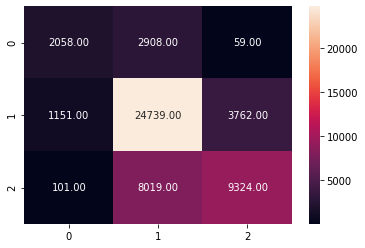

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cf = confusion_matrix(y_test, tpot.predict(x_test))
sns.heatmap(cf,annot=True,fmt=".2f")

## Prepare Test Data

In [ ]:
#read in test data
test_data = pd.read_csv("/content/test_values.csv", index_col='building_id')

test_data.head()

In [ ]:
test = test_data.copy()
# remove index Name
test = test.rename_axis(None).reset_index()
test.drop('index',axis=1,inplace=True)
print(test.head())

In [ ]:
X_test_scaled=sc.transform(test)
X_test_scaled

array([[ 0.38583526, -0.25459693,  1.38470151, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369, -1.35706613,  1.57118872, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.00822114, -1.65267326,  1.03832894, ..., -0.01207634,
        -0.00939496, -0.07173057],
       ...,
       [ 1.00822114,  1.05382805,  0.3987875 , ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369,  0.82364218, -1.46608461, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.50612985, -1.6114821 ,  0.04884974, ..., -0.01207634,
        -0.00939496, -0.07173057]])

## Predictions

In [ ]:
y_test_pred = tpot.fitted_pipeline_.predict(X_test_scaled)

In [ ]:
#create submission file
submission = pd.DataFrame(data=y_test_pred, columns=['damage_grade']).set_index(test_data.index)

In [ ]:
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


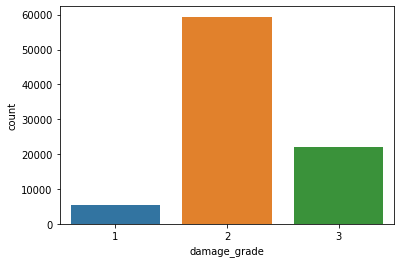

In [ ]:
sns.countplot(x='damage_grade',data=submission)

In [ ]:
submission = submission.reset_index()
submission.to_csv("tpot_classifier.csv",index=False)

**scored 0.6933 on 'Richter's Predictor: Modeling Earthquake Damage'!**

## AutoSklearn

In [ ]:
# To measure execution time of code
!pip install ipython-autotime
%load_ext autotime
#


time: 151 µs (started: 2021-03-20 12:16:03 +00:00)


In [ ]:
# Autosklearn pre-requisite
!apt-get install swig -y


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (814 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [ ]:
#
# Autosklearn pre-requisite
!pip install Cython numpy


time: 2.02 s (started: 2021-03-20 12:16:23 +00:00)


In [ ]:
# Automated library for machine learning model selection
!pip install auto-sklearn


     |████████████████████████████████| 6.1MB 6.7MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 675kB 54.6MB/s 
     |████████████████████████████████| 952kB 51.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.0MB 48.4MB/s 
     |████████████████████████████████| 266kB 57.2MB/s 
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.18-cp37-cp37m-linux_x86_64.whl size=2879775 sha256=aea76cb92e1524d15d80d8491c818362b3c6485c41f3012d99d4ce633c552fe4
  Stored in directory: /root/.cache/pip/wheels/39/ea/40/d93931850f700427db0a84180829c709d30484c9475040c7bd
Successfully built ConfigSpace
  Created wheel for auto-sklearn: filename=auto_sklearn-0.12.4-cp37-none-any.whl size=6367618 sha256=04f1552c240287514f7bf8126f288691927e7f991be7b8edcebc3e2099820a54
  Stored in directory: /root/.cache/pip/wheels/a5/88/34/2a7ba

time: 1min 9s (started: 2021-03-20 12:16:27 +00:00)


In [ ]:
# Autosklearn pre-requisite
!pip install scikit-learn==0.24.1


In [ ]:
#
# Autosklearn pre-requisite
!python -m pip install "dask[distributed]" --upgrade

     |████████████████████████████████| 931kB 8.5MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [ ]:
import sklearn
import autosklearn.classification as classifier
from sklearn.model_selection import train_test_split

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,2,4,2,4,3,2,9,1,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,0,4,2,3,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,2,4,2,4,2,2,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,2,4,2,4,2,3,9,0,1,0,0,0,0,1,1,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,2,4,2,4,2,3,9,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cat_features

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [ ]:
test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,17,596,11307,3,20,7,6,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
1,6,141,11987,2,25,13,5,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,2,5,4,5,2,4,2,4,3,3,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
3,26,39,633,1,0,19,3,2,4,0,2,1,2,9,0,0,0,0,0,1,0,0,0,0,0,3,2,1,0,0,1,0,0,0,0,0,0,0
4,17,289,7970,3,15,8,7,2,4,1,4,3,2,9,0,1,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn import model_selection
x_train,x_test,y_train,y_test=model_selection.train_test_split(X_scaled,Y.values,test_size=0.2,random_state=42,stratify=Y)

In [ ]:
automlclassifier = classifier.AutoSklearnClassifier() # Default duration is 3600 seconds (1 hour)
automlclassifier.fit(x_train, y_train)

AutoSklearnClassifier(per_run_time_limit=360)

In [ ]:
# Print the final ensemble constructed by auto-sklearn
print(automlclassifier.show_models())

[(0.420000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'adaboost', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'select_rates_classification', 'classifier:adaboost:algorithm': 'SAMME.R', 'classifier:adaboost:learning_rate': 0.8148153787947852, 'classifier:adaboost:max_depth': 5, 'classifier:adaboost:n_estimators': 75, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.004510052724702494, 'feature_preprocessor:select_rates_classification:alpha': 0.018293034787158283, 'feature_preprocessor:select_rates_classification:score_func': 'mutual_info_classif'},
d

In [ ]:
print(automlclassifier.sprint_statistics())

auto-sklearn results:
  Dataset name: 36c6a588-8982-11eb-81e4-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.733455
  Number of target algorithm runs: 41
  Number of successful target algorithm runs: 20
  Number of crashed target algorithm runs: 5
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 11



In [ ]:
# import accuracy score from sklearn.metrics
from sklearn.metrics import accuracy_score,f1_score
# Generate predictions on the validation data
pred = automlclassifier.predict(x_test)
#Accuracy score
print('Accuracy  Score is: ', accuracy_score(y_test, pred))
# F1 Score 
print('Weighted F1 Score is: ', f1_score(y_test, pred, average='weighted'))

Accuracy  Score is:  0.7395867308762303
Weighted F1 Score is:  0.735189055630048


In [ ]:
test_scaled 

array([[ 0.38583526, -0.25459693,  1.38470151, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369, -1.35706613,  1.57118872, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.00822114, -1.65267326,  1.03832894, ..., -0.01207634,
        -0.00939496, -0.07173057],
       ...,
       [ 1.00822114,  1.05382805,  0.3987875 , ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369,  0.82364218, -1.46608461, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.50612985, -1.6114821 ,  0.04884974, ..., -0.01207634,
        -0.00939496, -0.07173057]])

In [ ]:
# Make predictions
target = automlclassifier.predict(test_scaled)

In [ ]:
#create submission file
submission = pd.DataFrame(data=target, columns=['damage_grade']).set_index(test_data.index)

In [ ]:
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


## Visiualize Predictions

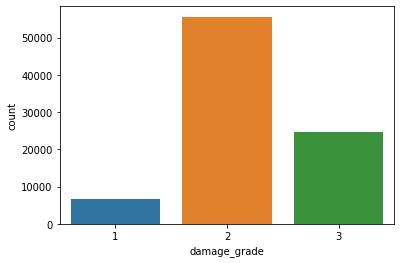

In [ ]:
sns.countplot(x='damage_grade',data=submission)

## Save predictions

In [ ]:
submission = submission.reset_index()
submission.to_csv("autosklearn_classifier.csv",index=False)

In [ ]:
submission.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


**scored 0.7357 on 'Richter's Predictor: Modeling Earthquake Damage'!**

## Voting Classifier

In [23]:
x_train.shape,y_train.shape


((208480, 38), (208480,))

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [30]:
models =[]
models.append(('knn1',KNeighborsClassifier(n_neighbors=2)))
models.append(('knn2',KNeighborsClassifier(n_neighbors=3)))
models.append(('knn3',KNeighborsClassifier(n_neighbors=5)))
models.append(('knn4',KNeighborsClassifier(n_neighbors=7)))
models.append(('knn5',KNeighborsClassifier(n_neighbors=9)))
models.append(('knn6',KNeighborsClassifier(n_neighbors=12)))


In [32]:
ensemble = VotingClassifier(estimators = models,voting='hard')

In [33]:
ensemble.fit(x_train,y_train)

VotingClassifier(estimators=[('knn1',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=2,
                                                   p=2, weights='uniform')),
                             ('knn2',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=3,
                                                   p=2, weights='uniform')),
                             ('knn3',
                      

In [35]:
y_pred = ensemble.predict(x_test)

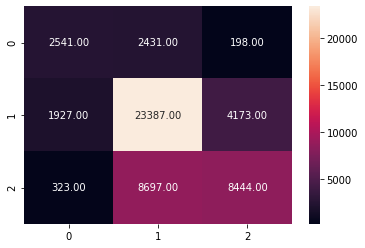

In [39]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,plot_confusion_matrix
cf = confusion_matrix(y_test,y_pred)
sns.heatmap(cf,annot=True,fmt=".2f")

In [41]:
f1_score(y_test,y_pred,average="micro")

0.6594654745687919

In [42]:
f1_score(y_test,y_pred,average="macro")

0.5995856482142162

In [43]:
accuracy_score(y_test,y_pred)

0.6594654745687919

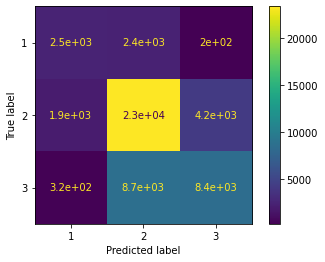

In [44]:
plot_confusion_matrix(ensemble, x_test, y_test)  

## Predictions

In [45]:
X_test_scaled=sc.transform(test)
X_test_scaled

array([[ 0.38583526, -0.25459693,  1.38470151, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369, -1.35706613,  1.57118872, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.00822114, -1.65267326,  1.03832894, ..., -0.01207634,
        -0.00939496, -0.07173057],
       ...,
       [ 1.00822114,  1.05382805,  0.3987875 , ..., -0.01207634,
        -0.00939496, -0.07173057],
       [-0.98341369,  0.82364218, -1.46608461, ..., -0.01207634,
        -0.00939496, -0.07173057],
       [ 1.50612985, -1.6114821 ,  0.04884974, ..., -0.01207634,
        -0.00939496, -0.07173057]])

In [46]:
test_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
y_test_pred = ensemble.predict(X_test_scaled)

In [48]:
#create submission file
submission = pd.DataFrame(data=y_test_pred, columns=['damage_grade']).set_index(test_data.index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


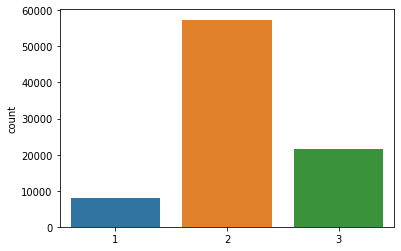

In [49]:
sns.countplot(y_test_pred)

In [50]:
submission = submission.reset_index()
submission.to_csv("votingclassifier.csv",index=False)

**Score 0.6616**